# Training neural networks using real data

## Classification of cats and dogs

We construct a small neural network that can distinguish images of cats and dogs

#### Google Colab

In [0]:
# Run if we use google collab

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Plan

* Load and prepare dataset
* How to train a real neural network
* Define neural network and run numerical experiments

Import all libraries and functions

In [0]:
import os

from matplotlib import pyplot as plt
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchsummary import summary

Define some constants. We'll need them later.

In [0]:
### Let's have a cell with global hyperparameters for the CNNs in this notebook

# Path to a directory with image dataset and subfolders for training, validation and final testing
DATA_PATH = 'data' # PATH TO THE DATASET

# Number of threads for data loader
NUM_WORKERS = 4

# Image size: even though image sizes are bigger than 96, we use this to speed up training
SIZE_H = SIZE_W = 96
N_CHANNELS = 3

# Number of classes in the dataset
NUM_CLASSES = 2

# Epochs: number of passes over the training data, we use it this small to reduce training babysitting time
EPOCH_NUM = 30

# Batch size: for batch gradient descent optimization, usually selected as 2**K elements
BATCH_SIZE = 128

# Images mean and std channelwise
image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

# Last layer (embeddings) size for CNN models
EMBEDDING_SIZE = 256

In [0]:
# use GPU if available. This trick can speed up training!
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

# Load and prepare dataset

## Datasets in pytorch

To learn models we need to load the data to memory. 
Common libraries for these problems are:
* for images `pillow`, `opencv`
* for audio `scipy`, `librosa`
* for texts `nltk`

After dataloading we need to transfer it to `torch.Tensor` format and do preprocessing.

Then we can pass them to model.

### Load data

We solve the competition [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats)

A smaller version of dataset is at the link:

In [0]:
!wget -nc https://www.dropbox.com/s/gqdo90vhli893e0/data.zip
!unzip -n data.zip -d data

--2020-01-28 11:55:18--  https://www.dropbox.com/s/gqdo90vhli893e0/data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/gqdo90vhli893e0/data.zip [following]
--2020-01-28 11:55:18--  https://www.dropbox.com/s/raw/gqdo90vhli893e0/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfa077cd021bf0f134e0a00eb46.dl.dropboxusercontent.com/cd/0/inline/AxCHn8R0lPcxKqh-sCC0zkuOp13z14AwqFBSQcLjVNFEAZPL7AMeqPb92CFGfpcqulawFHgzLqt8P2G2jT_KleV1VUFI1tWUcxaIhQ6xpsOBCw/file# [following]
--2020-01-28 11:55:18--  https://ucfa077cd021bf0f134e0a00eb46.dl.dropboxusercontent.com/cd/0/inline/AxCHn8R0lPcxKqh-sCC0zkuOp13z14AwqFBSQcLjVNFEAZPL7AMeqPb92CFGfpcqulawFHgzLqt8P2G2jT_KleV1VUFI1tWUcxaIhQ6xpsOBCw/file
Resolving ucfa077cd021bf0f134e0

The standard structure for dataset: each class has his own folder. In our case there are two classes: cats and dogs.

```
DATA_PATH/dog/xxx.png
DATA_PATH/dog/xxy.png
DATA_PATH/dog/xxz.png
... # other images of dogs

DATA_PATH/cat/123.png
DATA_PATH/cat/nsdf3.png
DATA_PATH/cat/asd932_.png
... # other images of cats
```

Pytorch has specific dataloader for images - `ImageFolder`

After loading it can give a pair of image + label by index.

Also we need some transformations of images for the loaded image.

1. All images have different sizes, but input of NN has fixed dimension. So we start with transformation to `96x96` image.
2. Change type of data to `torch.Tensor`, so NN can work with them (we start with `numpy` format by default)
3. Normalize data sample: substract mean values and divide by std

In [0]:
transformer = transforms.Compose([
    transforms.Resize((SIZE_H, SIZE_W)),        # scaling images to fixed size
    transforms.ToTensor(),                      # converting to tensors
    transforms.Normalize(image_mean, image_std) # normalize image data per-channel
])

Create a dataset for training, validation and testing

In [0]:
train_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'train_11k'), transform=transformer)
val_dataset   = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'val'), transform=transformer)
test_dataset  = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'test_labeled'), transform=transformer)

Keep sizes of datasets

In [0]:
n_train, n_val, n_test = len(train_dataset), len(val_dataset), len(test_dataset)

Real datasets can have sizes up to terabytes, so we can't keep all data in RAM memory. So we need a dataloaders `DataLoader`

Dataloader:


*   Split dataset to parts of equal sizes (batches). In our case the batch size is 128.
*   Drop these parts for training using only on batch

In [0]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)

In [0]:
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

In [0]:
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

Also we need a function for visulization of images

In [0]:
def plot_from_loader(loader):
    data_batch, label_batch = next(iter(loader))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)
    class_names = loader.dataset.classes
    for i in range(grid_size[0] * grid_size[1]):
        # read images from batch to numpy.ndarray and change axes order [H, W, C] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])
        
        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(image_std * batch_image_ndarray + image_mean, 0, 1)
        
        # display batch samples with labels
        sample_title = 'Label = %d (%s)' % (label_batch[i], class_names[label_batch[i]])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)

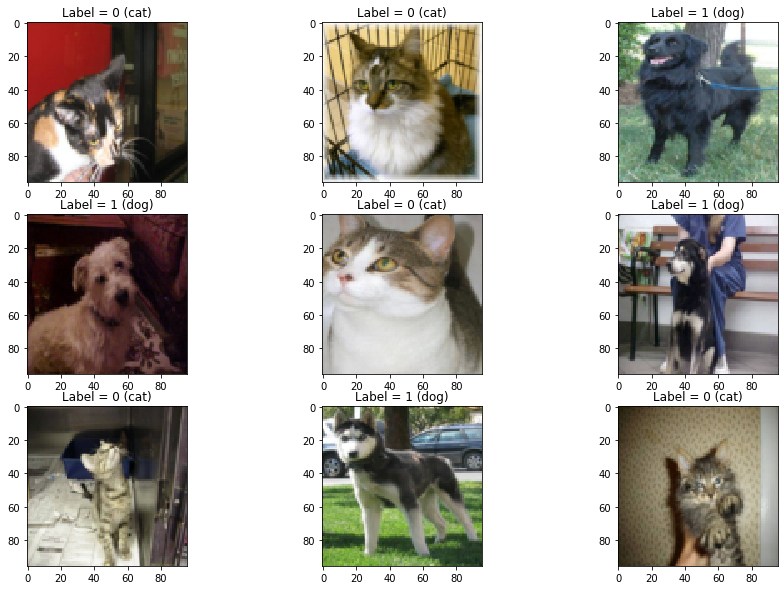

In [0]:
# each run outputs different images, as we load random parts of the initial dataset
plot_from_loader(train_loader)

# Training of a Neural network

Below we'll create an algorithm for training of Neural networks (training loop)

The function `train_model` is a high-level function for training by epochs (full processing of a dataset by batches) and validation.

Als we have a separate function for estimation of quality of model using a separate test dataset `test_model`

In [0]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs):
    '''
    model: neural network for training,
    train_loader, val_loader: data loaders
    loss_fn: loss function (we minimize it)
    opt: optimizer (how we update parameters of Neural network)
    n_epochs: number of epochs (full runs through the dataset)
    '''
    train_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            opt.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            opt.step()
            train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        for X_batch, y_batch in val_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # compute logits
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss_value = np.mean(train_loss[-n_train // BATCH_SIZE :])
        val_accuracy_value = np.mean(val_accuracy[-n_val // BATCH_SIZE :]) * 100
        
        print(f"  training loss (in-iteration): \t{train_loss_value:.6f}")
        print(f"  validation accuracy: \t\t\t{val_accuracy_value:.2f} %")

    return train_loss, val_accuracy

In [0]:
def test_model(model, test_loader, subset='test'):
    model.train(False) # disable dropout / use averages for batch_norm
    test_batch_acc = []
    for X_batch, y_batch in test_loader:
        logits = model(X_batch.to(device))
        y_pred = logits.max(1)[1].data
        test_batch_acc.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    test_accuracy = np.mean(test_batch_acc)
    
    print("Results:")
    print(f"  {subset} accuracy:\t\t{test_accuracy * 100:.2f} %")
    if test_accuracy > 0.9:
        print("Amazing!")
    elif test_accuracy > 0.7:
        print("Good!")
    else:
        print("We need more magic! Follow instructons below")
    return test_accuracy

# Creation of fully-connected Neural Network

THe workflow is the following:
Мы сконструируем простую нейросеть из полносвязных слоёв и натренируем её на 

*   construct a Neural Network model fully-connected architecture
*   train the model using available data

Usually convolutional architectures are better (but the workflow is quite similar)

We need another preprocessing step: transform an image to a one-dimensional vector.

We'll use a layer that transforms data to vector-form

In [0]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Our model is a forward path along parts of our neural network.

For more common defition of architecture we can use `Sequential` function

In [0]:
model = nn.Sequential(
    # reshape image from matrix to vector
    Flatten(),

    # create network with different layers
    nn.Linear(N_CHANNELS * SIZE_H * SIZE_W, 256),
    nn.ReLU(),
    nn.Dropout(0.05),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.05),

    # end the network with a layer of size that is equal to number of classes. The outputs of this layer are class probabilities
    nn.Linear(128, NUM_CLASSES),
    nn.Sigmoid(),
)

model = model.to(device)

Print info about model and its' performance

In [0]:
summary(model, (N_CHANNELS, SIZE_H, SIZE_W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 27648]               0
            Linear-2                  [-1, 256]       7,078,144
              ReLU-3                  [-1, 256]               0
           Dropout-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
              ReLU-6                  [-1, 128]               0
           Dropout-7                  [-1, 128]               0
            Linear-8                    [-1, 2]             258
           Sigmoid-9                    [-1, 2]               0
Total params: 7,111,298
Trainable params: 7,111,298
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.22
Params size (MB): 27.13
Estimated Total Size (MB): 27.45
-------------------------------------

### Run model training

In [0]:
opt = torch.optim.Adam(model.parameters(), lr=3e-4)

loss_fn = nn.CrossEntropyLoss()

In [0]:
train_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_fn, opt, 5)

Epoch 1 of 5 took 44.455s
  training loss (in-iteration): 	0.656379
  validation accuracy: 			60.94 %
Epoch 2 of 5 took 44.068s
  training loss (in-iteration): 	0.619709
  validation accuracy: 			60.29 %
Epoch 3 of 5 took 44.105s
  training loss (in-iteration): 	0.592475
  validation accuracy: 			61.77 %
Epoch 4 of 5 took 44.028s
  training loss (in-iteration): 	0.566567
  validation accuracy: 			61.74 %
Epoch 5 of 5 took 44.226s
  training loss (in-iteration): 	0.544833
  validation accuracy: 			62.39 %


In [0]:
# save the model, as it is good
best_model = model

Check out different architectures and different number of epochs. 15 epochs are often enough.

### Check the quality for the test data

In [0]:
val_acc = test_model(best_model, val_loader, 'val')
test_acc = test_model(best_model, test_loader, 'test')

Results:
  val accuracy:		62.39 %
We need more magic! Follow instructons below
Results:
  test accuracy:		64.90 %
We need more magic! Follow instructons below


# Bonus part: convolutions

### First step

**conv-pool-conv-pool-dense-dense-everybody!**

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3 classic convolutional blocks `convolution->relu->pool`: 
  * 3x3 convolution with 128 filters and _ReLU_ activation
  * 2x2 pooling (or set previous convolution stride to 3)
 * Flatten
* 30% Dropout 
* Dense layer with 256 neurons and _ReLU_ activation
* 30% dropout
* Output dense layer.

__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with learning_rate=3e-4 (Karpathy Constant)

If everything is right, you should get at least __75%__ validation accuracy.

__HACK_OF_THE_DAY__ :the number of channels must be in the order of the number of class_labels

__HACK_OF_THE_DAY_2__ : you may set stride=2 for Conv2d layers to increase learning speed, but keep in mind tensor shapes

In [0]:
model_cnn = nn.Sequential()

# Your code here: CONV->POOL->CONV-POOL->... as many as you wish

# End of your code here
# global average pooling
model_cnn.add_module('gap_5', nn.AvgPool2d(20))
# dropout for regularization
model_cnn.add_module('dropout_5', nn.Dropout(0.3))
# "flatten" the data
model_cnn.add_module('flat', Flatten())
# last fully-connected layer, used to create embedding vectors
model_cnn.add_module('fc_6', nn.Linear(48, EMBEDDING_SIZE))
model_cnn.add_module('relu_6', nn.ReLU())

model_cnn.add_module('dropout_6', nn.Dropout(0.3))

# logits for NUM_CLASSES=2 classes
model_cnn.add_module('fc_logits', nn.Linear(EMBEDDING_SIZE, NUM_CLASSES))
model_cnn.add_module('fc_preds', nn.Sigmoid())

# move model to computing device
model_cnn = model_cnn.to(device)


__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

Let's see the basic structure of our model and at the same time perform a sanity check for tensor dimensions.

In [0]:
summary(model_cnn, (N_CHANNELS, SIZE_H, SIZE_W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         AvgPool2d-1              [-1, 3, 4, 4]               0
           Dropout-2              [-1, 3, 4, 4]               0
           Flatten-3                   [-1, 48]               0
            Linear-4                  [-1, 256]          12,544
              ReLU-5                  [-1, 256]               0
           Dropout-6                  [-1, 256]               0
            Linear-7                    [-1, 2]             514
           Sigmoid-8                    [-1, 2]               0
Total params: 13,058
Trainable params: 13,058
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.01
Params size (MB): 0.05
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


#### Training

In [0]:
opt = torch.optim.Adam(model_cnn.parameters(), lr=3e-4)
opt.zero_grad()

In [0]:
number_of_epochs = 20
opt, losses_cnn = train_model(model_cnn,
                              train_loader,
                              val_loader,
                              loss_fn,
                              opt, number_of_epochs)

Epoch 1 of 20 took 45.122s
  training loss (in-iteration): 	0.687532
  validation accuracy: 			53.28 %
Epoch 2 of 20 took 45.019s
  training loss (in-iteration): 	0.680725
  validation accuracy: 			55.34 %
Epoch 3 of 20 took 45.541s
  training loss (in-iteration): 	0.675519
  validation accuracy: 			56.85 %
Epoch 4 of 20 took 45.591s
  training loss (in-iteration): 	0.672422
  validation accuracy: 			57.15 %
Epoch 5 of 20 took 45.496s
  training loss (in-iteration): 	0.668438
  validation accuracy: 			58.21 %
Epoch 6 of 20 took 45.120s
  training loss (in-iteration): 	0.664646
  validation accuracy: 			58.63 %
Epoch 7 of 20 took 45.151s
  training loss (in-iteration): 	0.663784
  validation accuracy: 			58.78 %
Epoch 8 of 20 took 44.926s
  training loss (in-iteration): 	0.662069
  validation accuracy: 			58.44 %
Epoch 9 of 20 took 45.336s
  training loss (in-iteration): 	0.657645
  validation accuracy: 			58.56 %
Epoch 10 of 20 took 46.722s
  training loss (in-iteration): 	0.657433
  v

ValueError: ignored

**A kind reminder again:** don't wait for too many  epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```
```
#### Evaluation 


In [0]:
# best_model_cnn = None
# with open(ckpt_name_cnn, 'rb') as f:
#     best_model_cnn = torch.load(f)

val_accuracy = test_model(model_cnn, val_loader, subset='val')
test_accuracy = test_model(model_cnn, test_loader, subset='test')

Results:
  val accuracy:		59.76 %
We need more magic! Follow instructons below
Results:
  test accuracy:		61.33 %
We need more magic! Follow instructons below
